In [3]:
%load_ext autoreload
%autoreload 2

import halo_cnn as hc
from tools.plot_tools import binned_plot
from tools.catalog import Catalog

get_centers = lambda edges: np.array([(edges[i]+edges[i+1])/2. for i in range(len(edges)-1)])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


2023-07-03 07:59:13.015899: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [5]:
wdir = '/hildafs/home/mho1/hilda/halo_cnn'

# John's X-ray data

## Original ICM+AGN

In [6]:
inputdir = join(wdir, 'data_raw/magneticum',
                'MagneticumPhotJohnSoltis100121/eROSITA_clusters')
# inputdir = '/hildafs/home/mho1/hilda/ICM_AGN_clusters/'

snz = {112: 0.29,
       116: 0.25,
       120: 0.21,
       128: 0.14,
       132: 0.1,
       136: 0.07,
      }

flist = os.listdir(inputdir)
flist = [x for x in flist if int(x[5:8]) in  snz]

In [7]:
# Load Cluster Metadata

cldatX = None

for i, j in enumerate(flist):
    if i%200==0:
        print(i,'/',len(flist))
    
    f = join(inputdir,
             j,
             'job.par')
    
    with open(f, 'r') as file:
        s = file.read()

    s = [x.split(' ') for x in s.split('\n')]
    
    if cldatX is None:
        cldatX = pd.DataFrame(columns = [x[0] for x in s[:-1]],
                             index = range(len(flist)))
    
    cldatX.loc[i] = [x[-1] for x in s[:-1]]
    
cldatX['SnapNum'] = cldatX['SnapNum'].apply(lambda x: int(x[5:]))
cldatX[['csv_x','csv_y','csv_z',
       'csv_vx','csv_vy','csv_vz']] = cldatX[['csv_x','csv_y','csv_z',
                                             'csv_vx','csv_vy','csv_vz']].astype(float)/1e3
cldatX['redshift'] = cldatX['SnapNum'].apply(lambda x: snz[x])

0 / 2001
200 / 2001
400 / 2001
600 / 2001
800 / 2001
1000 / 2001
1200 / 2001
1400 / 2001
1600 / 2001
1800 / 2001
2000 / 2001


### Example system

In [10]:
i = np.random.choice(flist)

f = join(inputdir,
         i,
         'phlist.fits')

print(f)

hdul = fits.open(f)
dat = np.array(hdul[2].data)
hdul.close()

/hildafs/home/mho1/hilda/halo_cnn/data_raw/magneticum/MagneticumPhotJohnSoltis100121/eROSITA_clusters/snap_128_cluster_313_OG_081121_set/phlist.fits


Text(0.5, 1.0, 'snap_128_cluster_313_OG_081121_set')

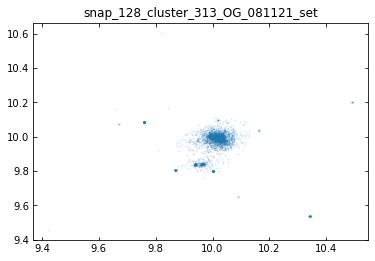

In [11]:
plt.plot(dat['RA'], dat['DEC'],'.', alpha=0.1, markersize=2)
plt.title(i)

In [12]:
sc = SkyCoord(ra=10.*u.degree, dec=10.0*u.degree, 
              distance=cosmo.comoving_distance(0.1))

v = sc.cartesian.xyz.value

r,_ = R.align_vectors([[0,0,1]],[v])
r = r.as_matrix()

catsc = SkyCoord(ra=dat['RA']*u.degree, dec=dat['DEC']*u.degree, 
                 distance=cosmo.comoving_distance(0.1))
xyz = r@(catsc.cartesian.xyz.value)

/hildafs/home/mho1/.conda/envs/jupy/lib/python3.7/site-packages/scipy/spatial/transform/rotation.py:1953: UserWarning: Optimal rotation is not uniquely or poorly defined for the given sets of vectors.
  warnings.warn("Optimal rotation is not uniquely or poorly defined "


(-4.0, 4.0)

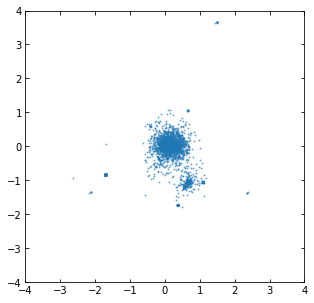

In [10]:
plt.figure(figsize=(5,5))
plt.plot(xyz[0], xyz[1],'.', alpha=0.5, markersize=2)
plt.xlim(-4,4)
plt.ylim(-4,4)

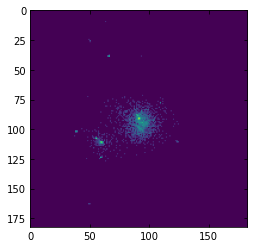

In [11]:
be = np.linspace(-3,3,184)

h, xe, ye = np.histogram2d(xyz[0], xyz[1], bins=be)
plt.imshow(np.log10(h+1))

### All systems

0 / 2001


/tmp/ipykernel_2802360/2717974712.py:11: UserWarning: Optimal rotation is not uniquely or poorly defined for the given sets of vectors.
  r1 = R.align_vectors([[0,0,1]],[v])[0].as_matrix()
/tmp/ipykernel_2802360/2717974712.py:12: UserWarning: Optimal rotation is not uniquely or poorly defined for the given sets of vectors.
  r2 = R.align_vectors([[1,-1,0]],[[1,0,0]])[0].as_matrix()


200 / 2001
400 / 2001
600 / 2001
800 / 2001
1000 / 2001
1200 / 2001
1400 / 2001
1600 / 2001
1800 / 2001
2000 / 2001


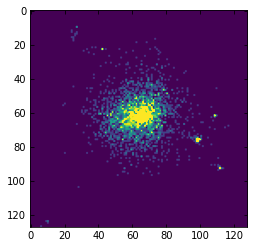

In [8]:
# Load photon data

Nbins = 128

# All clusters are placed at (10',10') in the sky
sc = SkyCoord(ra=10.*u.degree, dec=10.0*u.degree, 
              distance=cosmo.comoving_distance(0.1))
v = sc.cartesian.xyz.value
v /= np.linalg.norm(v)

r1 = R.align_vectors([[0,0,1]],[v])[0].as_matrix()
r2 = R.align_vectors([[1,-1,0]],[[1,0,0]])[0].as_matrix()
r = r2@r1

be = np.linspace(-3,3,Nbins+1)


imgs = np.zeros((len(flist), Nbins, Nbins))
for i, j in enumerate(flist):
    if i%200==0:
        print(i,'/',len(flist))
    
    f = join(inputdir,
             j,
             'phlist.fits')

    hdul = fits.open(f)
    dat = np.array(hdul[2].data)
    hdul.close()

    z = cldatX['redshift'][i]
    
    sc = SkyCoord(ra=10.*u.degree, dec=10.0*u.degree, 
                  distance=cosmo.comoving_distance(z))
    catsc = SkyCoord(ra=dat['RA']*u.degree, dec=dat['DEC']*u.degree, 
                     distance=cosmo.comoving_distance(z))
    xyz = r@(catsc.cartesian.xyz.value)

    h, xe, ye = np.histogram2d(xyz[0], xyz[1], bins=be)
    imgs[i] = h
    
plt.imshow(imgs[i], vmin=0, vmax=5)

#### Normalize photon counts by redshift

[-5.91320489] 4.328841905508774
0.5710897590699446
0.13128196869794873


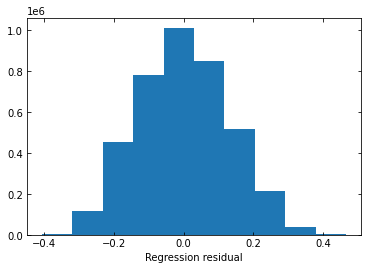

In [9]:
from sklearn.linear_model import LinearRegression

# x = np.log10(cldatX['csv_M500_msolh'].astype(float))
x = np.stack([ cldatX['SnapNum'].apply(lambda x: snz[x])], axis=1)
y =  np.log10(np.sum(imgs, axis=(1,2)))

reg = LinearRegression().fit(x,y)

print(reg.coef_, reg.intercept_)
print(reg.score(x,y))

Nm = reg.predict(x)

z = (x-(y-reg.intercept_)/reg.coef_).flatten()
plt.hist(z)
plt.xlabel('Regression residual')

print(np.std(z))

imgsX = imgs / 10**np.expand_dims(Nm, (1,2))
imgsX *= 10**y.mean()



Text(0.5, 1.0, 'normalized')

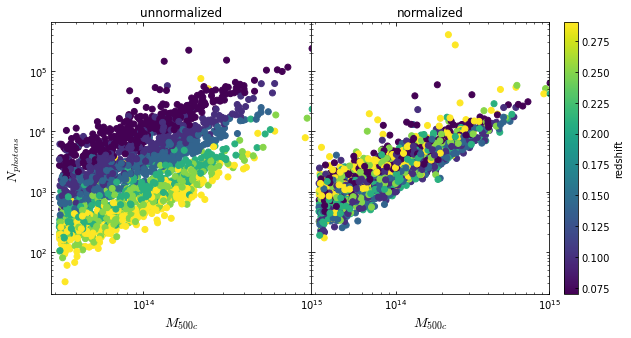

In [10]:

f,axs = plt.subplots(1,2, sharex=True, sharey=True, 
                     figsize=(10,5), gridspec_kw={'wspace':0,'width_ratios': [3.5,4]})

x = cldatX['csv_M500_msolh'].astype(float)
y1 = np.sum(imgs, axis=(1,2))
y2 = np.sum(imgsX, axis=(1,2))
c = cldatX['SnapNum'].apply(lambda x: snz[x])

axs[0].loglog()
axs[0].scatter(x,y1, c=c)
scatter = axs[1].scatter(x,y2, c=c)


axs[0].set_xlim(10**13.45,10**15)
plt.colorbar(scatter, label='redshift')
axs[0].set_xlabel('$M_{500c}$', fontsize=14)
axs[1].set_xlabel('$M_{500c}$', fontsize=14)
axs[0].set_ylabel('$N_{photons}$', fontsize=14)

axs[0].set_title('unnormalized')
axs[1].set_title('normalized')
# plt.savefig('temp/x-ray-relation.png')

In [11]:
np.save('/hildafs/home/mho1/hilda/for_people/adl/imgsX.npy', imgsX)
np.save('/hildafs/home/mho1/hilda/for_people/adl/massX.npy', np.log10(cldatX['csv_M500_msolh'].values.astype(float)))

### Multiband

/tmp/ipykernel_2802360/3015222370.py:9: UserWarning: Optimal rotation is not uniquely or poorly defined for the given sets of vectors.
  r1 = R.align_vectors([[0,0,1]],[v])[0].as_matrix()
/tmp/ipykernel_2802360/3015222370.py:10: UserWarning: Optimal rotation is not uniquely or poorly defined for the given sets of vectors.
  r2 = R.align_vectors([[1,-1,0]],[[1,0,0]])[0].as_matrix()


0 / 2001
200 / 2001
400 / 2001
600 / 2001
800 / 2001
1000 / 2001
1200 / 2001
1400 / 2001
1600 / 2001
1800 / 2001
2000 / 2001


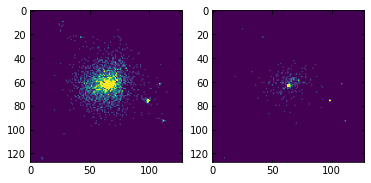

In [12]:
Nbins = 128

# All clusters are placed at (10',10') in the sky
sc = SkyCoord(ra=10.*u.degree, dec=10.0*u.degree, 
              distance=cosmo.comoving_distance(0.1))
v = sc.cartesian.xyz.value
v /= np.linalg.norm(v)

r1 = R.align_vectors([[0,0,1]],[v])[0].as_matrix()
r2 = R.align_vectors([[1,-1,0]],[[1,0,0]])[0].as_matrix()
r = r2@r1

be = np.linspace(-3,3,Nbins+1)


imgs = np.zeros((len(flist), Nbins, Nbins,2))
for i, j in enumerate(flist):
    if i%200==0:
        print(i,'/',len(flist))
    
    f = join(inputdir,
             j,
             'phlist.fits')

    hdul = fits.open(f)
    dat = np.array(hdul[2].data)
    hdul.close()

    z = cldatX['redshift'][i]
    
    sc = SkyCoord(ra=10.*u.degree, dec=10.0*u.degree, 
                  distance=cosmo.comoving_distance(z))
    
    # Energy bands of Chandra https://www.aanda.org/articles/aa/full_html/2021/03/aa39313-20/aa39313-20.html
    
    tdat = dat[dat['ENERGY']<1.2]
    
    tdat = dat[(dat['ENERGY']>0.2) & (dat['ENERGY']<2.3)]
    catsc = SkyCoord(ra=tdat['RA']*u.degree, dec=tdat['DEC']*u.degree, 
                     distance=cosmo.comoving_distance(z))
    xyz = r@(catsc.cartesian.xyz.value)

    h, xe, ye = np.histogram2d(xyz[0], xyz[1], bins=be)
    imgs[i,...,0] = h
    
    tdat = dat[(dat['ENERGY']>=2.3) & (dat['ENERGY']<8)]
    catsc = SkyCoord(ra=tdat['RA']*u.degree, dec=tdat['DEC']*u.degree, 
                     distance=cosmo.comoving_distance(z))
    xyz = r@(catsc.cartesian.xyz.value)

    h, xe, ye = np.histogram2d(xyz[0], xyz[1], bins=be)
    imgs[i,...,1] = h

f,axs = plt.subplots(1,2)
axs[0].imshow(imgs[i,...,0], vmin=0, vmax=5)
axs[1].imshow(imgs[i,...,1], vmin=0, vmax=5)

#### Normalize photon counts by redshift

[-5.94129035] 4.281027253760287
0.5666035945261272
0.13161235636376487


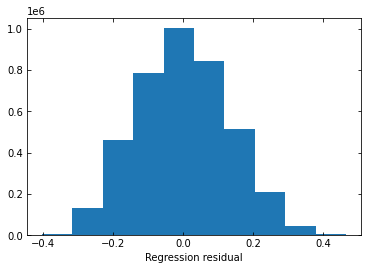

In [13]:
from sklearn.linear_model import LinearRegression

# x = np.log10(cldatX['csv_M500_msolh'].astype(float))
x = np.stack([ cldatX['SnapNum'].apply(lambda x: snz[x])], axis=1)
y =  np.log10(np.sum(imgs, axis=(1,2,3)))

reg = LinearRegression().fit(x,y)

print(reg.coef_, reg.intercept_)
print(reg.score(x,y))

z = (x-(y-reg.intercept_)/reg.coef_).flatten()
plt.hist(z)
plt.xlabel('Regression residual')
print(np.std(z))


Nm = reg.predict(x)

imgsXMB = imgs / 10**np.expand_dims(Nm, (1,2,3))
imgsXMB *= 10**y.mean()



Text(0.5, 1.0, 'normalized')

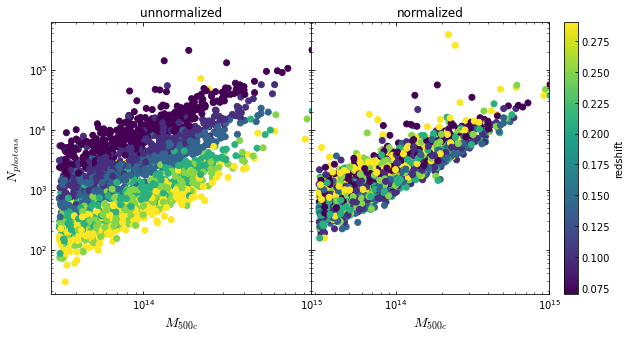

In [14]:

f,axs = plt.subplots(1,2, sharex=True, sharey=True, 
                     figsize=(10,5), gridspec_kw={'wspace':0,'width_ratios': [3.5,4]})

x = cldatX['csv_M500_msolh'].astype(float)
y1 = np.sum(imgs, axis=(1,2,3))
y2 = np.sum(imgsXMB, axis=(1,2,3))
c = cldatX['SnapNum'].apply(lambda x: snz[x])

axs[0].loglog()
axs[0].scatter(x,y1, c=c)
scatter = axs[1].scatter(x,y2, c=c)


axs[0].set_xlim(10**13.45,10**15)
plt.colorbar(scatter, label='redshift')
axs[0].set_xlabel('$M_{500c}$', fontsize=14)
axs[1].set_xlabel('$M_{500c}$', fontsize=14)
axs[0].set_ylabel('$N_{photons}$', fontsize=14)

axs[0].set_title('unnormalized')
axs[1].set_title('normalized')
# plt.savefig('temp/x-ray-relation.png')

# Dynamical Magneticum Catalogs

## fix magneticum data

In [1]:
import os
from os.path import join
import pandas as pd
import re

dirname = '/hildafs/home/mho1/hilda/halo_cnn/data_raw/magneticum'

In [3]:
flist = os.listdir(join(dirname, 'raw_catalogs'))

# x = 'magn_gal_sn136_z0.066340191.txt'# flist[0]
x = 'magn_gal_sn132.txt'

raw = pd.read_csv(join(dirname, 'raw_catalogs', x), delimiter=' ', skipinitialspace=True)

raw.head()

,#,UID,x[kpc/h],y[kpc/h],z[kpc/h],x_pix,y_pix,i_sector,m[Msol/h],sfr[Msol/year],host,dist[kpc/h],log10(m_cD/m),m_gas[Msol/h],vx[km/s],vy[km/s],vz[km/s],dv[km/s],vr[km/s],vt[km/s]
0,0,208891.69,203958.62,349892.88,9722,6890,6,2.157300e+13,1332.63,0,0.0000,0.00000,1.756560e+14,-268.95056,-95.936974,-189.035100,0.00,0.00,0.000,NaN
1,5,208904.62,204020.92,349861.16,9723,6887,6,6.266010e+11,0.00,0,71.0959,1.53692,0.000000e+00,-957.72211,-1193.786700,-9.772691,1308.36,-1167.27,591.016,NaN
2,6,208688.19,203714.89,350159.69,9713,6901,6,5.318720e+11,0.00,0,414.7340,1.60810,0.000000e+00,259.75153,965.424190,-403.422360,1204.98,-1021.08,639.818,NaN
3,4,208996.61,204182.42,349449.44,9727,6880,6,6.659550e+11,0.00,0,507.6750,1.51047,0.000000e+00,-355.45126,-249.384410,879.466130,1082.92,-1018.83,367.032,NaN
4,7,208249.52,203392.86,350635.84,9693,6916,6,4.780690e+11,0.00,0,1133.3400,1.65442,0.000000e+00,-756.09625,-906.896120,902.837770,1444.70,1396.63,369.557,NaN


In [4]:


# cols = raw.columns.values[1:]
cols = raw.columns.values

if cols[0]=='#':
    cols = cols[1:]
    dat = raw.iloc[:,:-1]
else:
    dat = raw

cols = [re.sub(r"\[[^()]*\]", "", x) for x in cols] # removing units
cols = [x if x!='m' else 'm_star' for x in cols] # replacing m with stellar mass

dat = pd.DataFrame(dat.values, columns=cols)

dat[['x','y','z']] /= 1e3
dat.index.name='ID'
dat = dat.reset_index()

dat.head()

,ID,UID,x,y,z,x_pix,y_pix,i_sector,m_star,sfr,host,dist,log10(m_cD/m),m_gas,vx,vy,vz,dv,vr,vt
0,0,0.0,208.89169,203.95862,349.89288,9722.0,6890.0,6.0,2.157300e+13,1332.63,0.0,0.0000,0.00000,1.756560e+14,-268.95056,-95.936974,-189.035100,0.00,0.00,0.000
1,1,5.0,208.90462,204.02092,349.86116,9723.0,6887.0,6.0,6.266010e+11,0.00,0.0,71.0959,1.53692,0.000000e+00,-957.72211,-1193.786700,-9.772691,1308.36,-1167.27,591.016
2,2,6.0,208.68819,203.71489,350.15969,9713.0,6901.0,6.0,5.318720e+11,0.00,0.0,414.7340,1.60810,0.000000e+00,259.75153,965.424190,-403.422360,1204.98,-1021.08,639.818
3,3,4.0,208.99661,204.18242,349.44944,9727.0,6880.0,6.0,6.659550e+11,0.00,0.0,507.6750,1.51047,0.000000e+00,-355.45126,-249.384410,879.466130,1082.92,-1018.83,367.032
4,4,7.0,208.24952,203.39286,350.63584,9693.0,6916.0,6.0,4.780690e+11,0.00,0.0,1133.3400,1.65442,0.000000e+00,-756.09625,-906.896120,902.837770,1444.70,1396.63,369.557


In [ ]:
flist = os.listdir(join(dirname, 'raw_catalogs'))

for f in flist:
    print(f)
    
    raw = pd.read_csv(join(dirname, 'raw_catalogs', f), delimiter=' ', skipinitialspace=True)

    cols = raw.columns.values

    if cols[0]=='#':
        cols = cols[1:]
        dat = raw.iloc[:,:-1]
    else:
        dat = raw

    cols = [re.sub(r"\[[^()]*\]", "", x) for x in cols] # removing units
    cols = [x if x!='m' else 'm_star' for x in cols] # replacing m with stellar mass

    dat = pd.DataFrame(dat.values, columns=cols)

    dat[['x','y','z']] /= 1e3 # distance in units of Mpc
    
    if 'clu' in f:
        dat.index.name='CLUID'
        dat['UID']=-1
    if 'gal' in f:
        dat.index.name='GALID'
        
    
    dat = dat.reset_index()

    dat.to_csv(join(dirname, 'raw_catalogs_fixed', f[:-4]+'.csv'))

## Catalogs

In [29]:
cat = Catalog().load(join(wdir, 'data_mocks','Magneticum_sn128_z=0.14_LOS-z_contam.p'))

Loading catalog from: /hildafs/home/mho1/hilda/halo_cnn/data_mocks/Magneticum_sn128_z=0.14_LOS-z_contam.p


In [30]:
cat.prop.head()

,CLUID,UID,x,y,z,x_pix,y_pix,i_sector,m500c,r500c,...,M_sat/M_cD,cshift,vx,vy,vz,rot_theta,rot_phi,rotation,Ngal,sigv
0,7683.0,-1.0,225.557690,123.734450,227.049950,10498.0,10624.0,10.0,7.043300e+12,250.902,...,0.324557,0.052310,166.418,83.5730,-16.7526,0.0,0.0,0.0,60,1217.981541
1,8395.0,-1.0,42.663820,212.467360,9.811566,1985.0,6494.0,4.0,7.044870e+12,250.915,...,0.256788,0.082912,-150.761,34.7678,154.5100,0.0,0.0,0.0,36,1258.003441
2,10119.0,-1.0,243.715020,242.446500,199.741670,11343.0,5099.0,6.0,7.045100e+12,250.912,...,0.010718,0.075408,-106.985,346.5000,165.9760,0.0,0.0,0.0,51,1077.952979
3,8895.0,-1.0,139.923910,11.193883,323.028910,6512.0,15862.0,13.0,7.045210e+12,250.913,...,0.471847,0.041295,142.216,64.2036,-463.3820,0.0,0.0,0.0,103,939.116008
4,8252.0,-1.0,7.140331,311.701840,260.391970,332.0,1875.0,0.0,7.045280e+12,250.919,...,0.223306,0.255242,-801.731,-16.7900,-108.5010,0.0,0.0,0.0,87,1155.206759


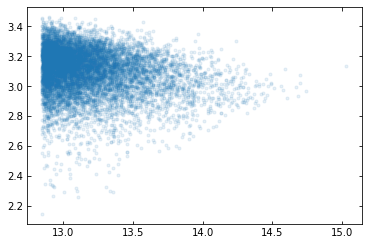

In [31]:
x = np.log10(cat.prop['sigv'])
y = np.log10(cat.prop['m500c'])

plt.plot(y,x,'.',alpha=0.1)

# Zuhone SZ data

In [116]:
inputdir = join(wdir, 'data_raw/magneticum',
                'zuhone_magneticum_sz/Box2_hr')

snz = {112: 0.29,
       116: 0.25,
       120: 0.21,
       128: 0.14,
       132: 0.1
      }


In [117]:
cldatSZ = pd.DataFrame()

for sn in snz.keys():
    
    flist = os.listdir(join(inputdir, f'snap_{sn}'))
    flist = [x for x in flist if x[-6]=='z']
    
    ids = [int(x.split('_')[3]) for x in flist]
    
    indcl = pd.DataFrame(ids, columns=['id'])
    indcl['SnapNum'] = sn
    
    cldatSZ = cldatSZ.append(indcl)
    
cldatSZ = cldatSZ.reset_index(drop=True)
cldatSZ[['CRVAL1', 'CRVAL2', 'CDELT']] = -1
imgsSZ = np.zeros(shape=(len(cldatSZ), 1024, 1024))

for i in range(len(cldatSZ)):
    if i%200==0: print(i,'/',len(cldatSZ))
    f = join(inputdir,
             f'snap_{cldatSZ.loc[i, "SnapNum"]}',
             f'snap_{cldatSZ.loc[i, "SnapNum"]}_szy_{cldatSZ.loc[i, "id"]}_z.fits')
    with fits.open(f) as hdul:
        imgsSZ[i] = hdul[0].data
        cldatSZ.loc[i, "CRVAL1"] = hdul[0].header['CRVAL1']/1e3
        cldatSZ.loc[i, "CRVAL2"] = hdul[0].header['CRVAL2']/1e3
        cldatSZ.loc[i, "CDELT"] = hdul[0].header['CDELT1']/1e3

0 / 2198
200 / 2198
400 / 2198
600 / 2198
800 / 2198
1000 / 2198
1200 / 2198
1400 / 2198
1600 / 2198
1800 / 2198
2000 / 2198


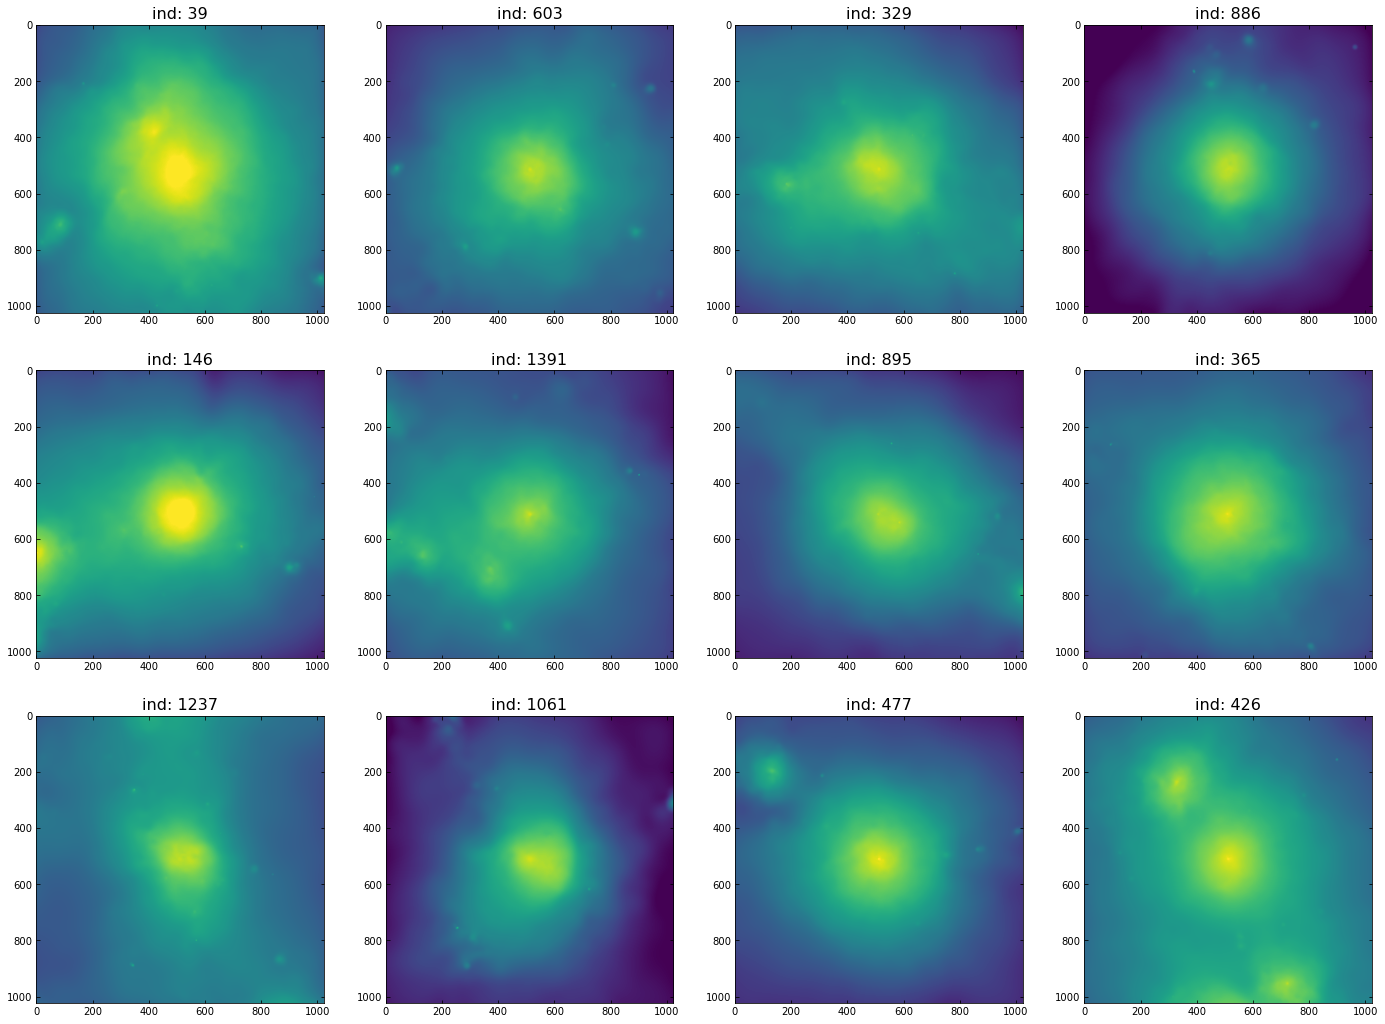

In [149]:
N,M = 4, 3

f = plt.figure(figsize=(6*N,6*M))
gs = mpl.gridspec.GridSpec(M, N)

for j in range(M):
    for i in range(N):
        ind = np.random.randint(len(cldatSZ))

        ax = f.add_subplot(gs[j,i])

        ax.imshow(np.log10(imgsSZ[ind]+1e-16), vmin=-9, vmax=-5)

        ax.set_title('ind: ' + str(cldatSZ.loc[ind, 'id']), fontsize=16)

## Calibration or something?
Not sure what I was doing here

In [29]:
c = 0

from collections import defaultdict
scale = defaultdict(list)
for i in range(len(cldat)):
    x = cldat.iloc[i]

    xid = int(x['cluster_id'])
    xsn = int(x['SnapNum'])

    j = (cldatSZ['id']==xid) & (cldatSZ['SnapNum']==xsn)
    
    if np.sum(j) > 0:
        scale[xsn].append(cldatSZ[j]['CRVAL1'].iloc[0]/x['csv_x'])

In [30]:
calib = {}
for key in scale.keys():
    calib[key] = np.mean(scale[key])

In [31]:
calib

{120: 1.1714938304419151,
 132: 1.2899820681601943,
 112: 1.0986117198103218,
 116: 1.1344676502612392,
 128: 1.2492109553970776}

In [163]:
tree = KDTree(cat.prop[['x','y']])

In [166]:
cldatSZtemp = cldatSZ[cldatSZ['SnapNum']==128]
imgsSZ = imgsSZ[(cldatSZ['SnapNum']==128).values]

xs = cldatSZtemp.apply(lambda x: x['CRVAL1']/calib[x['SnapNum']], 
                   axis=1)
ys = cldatSZtemp.apply(lambda x: x['CRVAL2']/calib[x['SnapNum']], 
                   axis=1)

IndexError: boolean index did not match indexed array along dimension 0; dimension is 537 but corresponding boolean dimension is 2198

In [165]:
sd,si = tree.query(list(zip(xs,ys)), p=2)

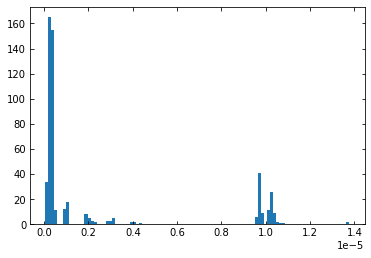

In [152]:
_ = plt.hist(d,100)

In [156]:
np.unique(cldatSZ['SnapNum'])

array([112, 116, 120, 128, 132])

# Combining multi

In [37]:
from scipy.spatial import KDTree
from astropy.cosmology import WMAP9 as cosmo

## Xray and Dyn

In [38]:
sndict = {112: 'Magneticum_sn112_z=0.29_LOS-z_contam.p',
          116: 'Magneticum_sn116_z=0.25_LOS-z_contam.p',
          120: 'Magneticum_sn120_z=0.21_LOS-z_contam.p',
          128: 'Magneticum_sn128_z=0.14_LOS-z_contam.p',
          132: 'Magneticum_sn132_z=0.1_LOS-z_contam.p',
          136: 'Magneticum_sn136_z=0.07_LOS-z_contam.p',
         }
snz = {112: 0.29,
       116: 0.25,
       120: 0.21,
       128: 0.14,
       132: 0.1,
       136: 0.07,
      }

In [39]:
cat_prop = []
cat_gal = []
cat_imgs = []


for snum in sndict.keys():
    print(snum)
    
    idat = cldat[cldat['SnapNum']==snum]
    iimgs = imgsX[cldat['SnapNum']==snum]
    icat = Catalog().load(join(wdir, 'data_mocks',sndict[snum]))
    
    tree = KDTree(icat.prop[['x','y','z']])
    
    ds, inds = tree.query(idat[['csv_x','csv_y','csv_z']], p=2)
    
#     if np.any(ds>1e-4):
#         raise('ds nuts')
    
    icat = icat[inds]
    icat.prop['redshift'] = snz[snum]
    
    cat_prop.append(icat.prop)
    cat_gal.append(icat.gal)
    cat_imgs.append(iimgs)
    

112
Loading catalog from: /hildafs/home/mho1/hilda/halo_cnn/data_mocks/Magneticum_sn112_z=0.29_LOS-z_contam.p
116
Loading catalog from: /hildafs/home/mho1/hilda/halo_cnn/data_mocks/Magneticum_sn116_z=0.25_LOS-z_contam.p
120
Loading catalog from: /hildafs/home/mho1/hilda/halo_cnn/data_mocks/Magneticum_sn120_z=0.21_LOS-z_contam.p
128
Loading catalog from: /hildafs/home/mho1/hilda/halo_cnn/data_mocks/Magneticum_sn128_z=0.14_LOS-z_contam.p
132
Loading catalog from: /hildafs/home/mho1/hilda/halo_cnn/data_mocks/Magneticum_sn132_z=0.1_LOS-z_contam.p
136
Loading catalog from: /hildafs/home/mho1/hilda/halo_cnn/data_mocks/Magneticum_sn136_z=0.07_LOS-z_contam.p


In [40]:
cat_prop = pd.concat(cat_prop)
cat_gal = np.concatenate(cat_gal, axis=0)
cat_imgs = np.concatenate(cat_imgs, axis=0)

cat_prop = cat_prop.reset_index(drop=True)

In [41]:
cat_imgs +=1
cat_imgs = np.log10(cat_imgs)

In [42]:
newcat = Catalog()

newcat.prop=cat_prop
newcat.gal=cat_gal
newcat.imgs=cat_imgs
newcat.par = icat.par

In [43]:
newcat.save(join(wdir, 'data_mocks', 'Magneticum_dynXray_z=0.1-0.29_LOS-z_contam.p'))

Pickle dumping to /hildafs/home/mho1/hilda/halo_cnn/data_mocks/Magneticum_dynXray_z=0.1-0.29_LOS-z_contam.p with protocol 4


### Plotting

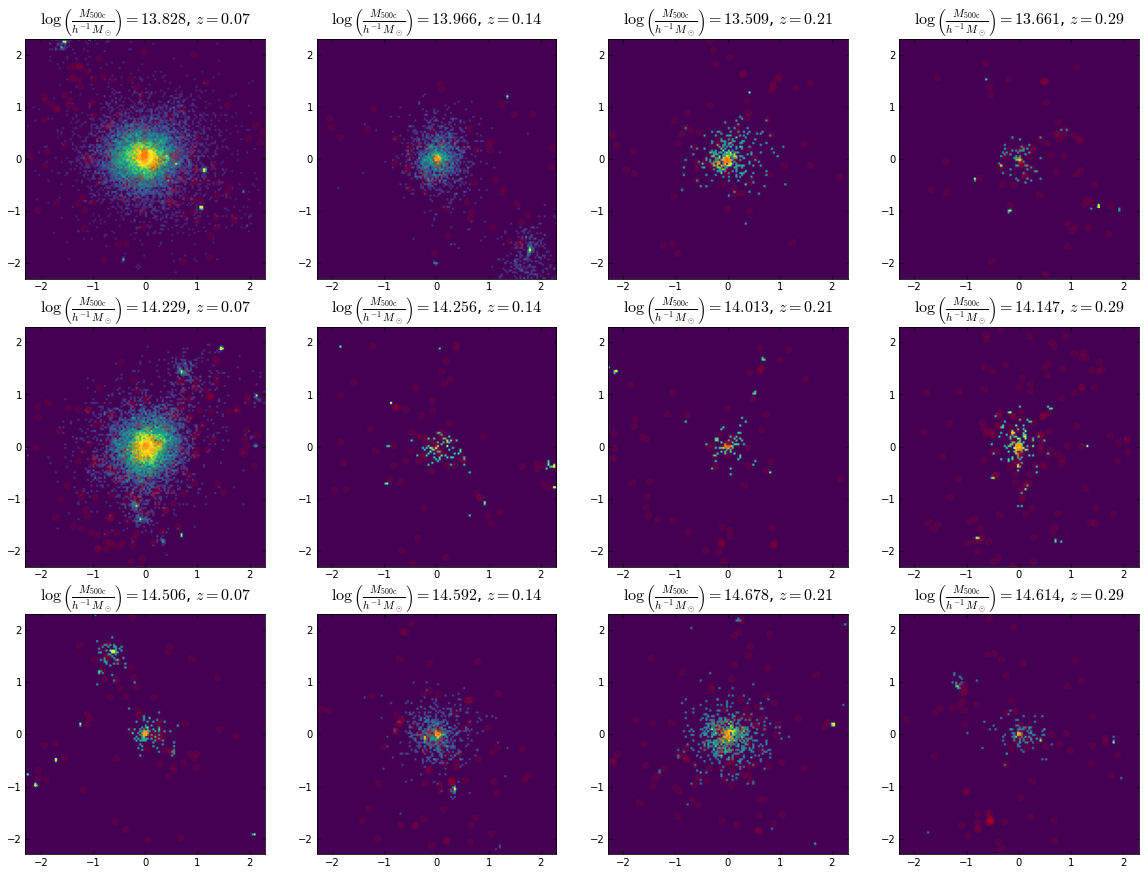

In [323]:
#as a sanity check, plot up a few clusters

n,m=3,4

zbins = [0.07,0.14,0.21,0.29]
mbins = np.linspace(13.5, 15, n+1)

f = plt.figure(figsize=(20,15))
gs = mpl.gridspec.GridSpec(n,m)

for i in range(n):
    for j in range(m):
        mask = cldat['redshift']==zbins[j]
        mask *= (10**mbins[i] <= cldat['csv_M500_msolh'].astype(float)) 
        mask *= cldat['csv_M500_msolh'].astype(float)< 10**mbins[i+1]
        
        ind = np.random.choice(np.argwhere(mask.values).flatten())
        
        ax = f.add_subplot(gs[i,j])
    
        im = newcat.imgs[ind]

        ax.imshow(np.rot90(im), vmin=0, vmax=1, #cmap='inferno',
                  extent=[-aperture,aperture,-aperture,aperture])

        x = newcat.gal[ind]['xproj']
        y = newcat.gal[ind]['yproj']
        ax.plot(x,y,'ro', alpha=0.1)

        ax.set_title(r'$\log\left(\frac{M_\mathrm{500c}}{h^{-1}\,M_\odot}\right) = '
                     f'{np.log10(float(cldat["csv_M500_msolh"][ind])):.3f}$'
                     f', $z={cldat["redshift"][ind]}$',
                     fontsize=16)
    
plt.savefig('temp/mag_xray.png')

In [256]:
len(newcat)

2001

# Full

In [119]:
sndict = {112: 'Magneticum_sn112_z=0.29_LOS-z_contam.p',
          116: 'Magneticum_sn116_z=0.25_LOS-z_contam.p',
          120: 'Magneticum_sn120_z=0.21_LOS-z_contam.p',
          128: 'Magneticum_sn128_z=0.14_LOS-z_contam.p',
          132: 'Magneticum_sn132_z=0.1_LOS-z_contam.p',
#           136: 'Magneticum_sn136_z=0.07_LOS-z_contam.p',
         }

In [136]:
cat_prop = []
cat_gal = []
cat_ximgs = []
cat_xmbimgs = []
cat_simgs = []


for snum in sndict.keys():
    print(snum)
    
    ixdat = cldatX[cldatX['SnapNum']==snum]
    iximgs = imgsX[cldatX['SnapNum']==snum]
    ixmbimgs = imgsXMB[cldatX['SnapNum']==snum]
    
    isdat = cldatSZ[cldatSZ['SnapNum'] == snum]
    isimgs = imgsSZ[cldatSZ['SnapNum'] == snum]
    
    
    inds = np.array([-1 for _ in range(len(ixdat))])
    for i in range(len(ixdat)):
        agw = np.argwhere(isdat['id'].values == int(ixdat['cluster_id'].iloc[i]))
        if len(agw)>0:
            inds[i] = agw[0]
            
    ixdat = ixdat.iloc[inds>0]
    iximgs = iximgs[inds>0]
    ixmbimgs = ixmbimgs[inds>0]
    inds = inds[inds>0]
    isdat =  isdat.iloc[inds]
    isimgs = isimgs[inds]
    
    
    icat = Catalog().load(join(wdir, 'data_mocks',sndict[snum]))
    
    
    
    # find dyn-xray
    tree = KDTree(icat.prop[['x','y','z']])
    dds, dinds = tree.query(ixdat[['csv_x','csv_y','csv_z']], p=2)

    
    
    icat = icat[dinds]
    icat.prop['redshift'] = snz[snum]
    
    cat_prop.append(icat.prop)
    cat_gal.append(icat.gal)
    cat_ximgs.append(iximgs)
    cat_xmbimgs.append(ixmbimgs)
    cat_simgs.append(isimgs)
    

112
Loading catalog from: /hildafs/home/mho1/hilda/halo_cnn/data_mocks/Magneticum_sn112_z=0.29_LOS-z_contam.p
116
Loading catalog from: /hildafs/home/mho1/hilda/halo_cnn/data_mocks/Magneticum_sn116_z=0.25_LOS-z_contam.p
120
Loading catalog from: /hildafs/home/mho1/hilda/halo_cnn/data_mocks/Magneticum_sn120_z=0.21_LOS-z_contam.p
128
Loading catalog from: /hildafs/home/mho1/hilda/halo_cnn/data_mocks/Magneticum_sn128_z=0.14_LOS-z_contam.p
132
Loading catalog from: /hildafs/home/mho1/hilda/halo_cnn/data_mocks/Magneticum_sn132_z=0.1_LOS-z_contam.p


In [137]:
cat_prop = pd.concat(cat_prop)
cat_gal = np.concatenate(cat_gal, axis=0)
cat_ximgs = np.concatenate(cat_ximgs, axis=0)
cat_xmbimgs = np.concatenate(cat_xmbimgs, axis=0)
cat_simgs = np.concatenate(cat_simgs, axis=0)

cat_prop = cat_prop.reset_index(drop=True)

In [140]:
cat_ximgs = np.log10(cat_ximgs+1)
cat_ximgs -= cat_ximgs.mean()
cat_ximgs /= cat_ximgs.std()

cat_xmbimgs = np.log10(cat_xmbimgs+1)
cat_xmbimgs -= cat_xmbimgs.mean()
cat_xmbimgs /= cat_xmbimgs.std()

cat_simgs = np.log10(cat_simgs+1e-16)
cat_simgs -= cat_simgs.mean()
cat_simgs /= cat_simgs.std()

In [141]:
newcat = Catalog()

newcat.prop=cat_prop
newcat.gal=cat_gal
newcat.ximgs=cat_ximgs
newcat.xmbimgs=cat_xmbimgs
newcat.simgs=cat_simgs
newcat.par = icat.par

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/hildafs/home/mho1/.conda/envs/jupy/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


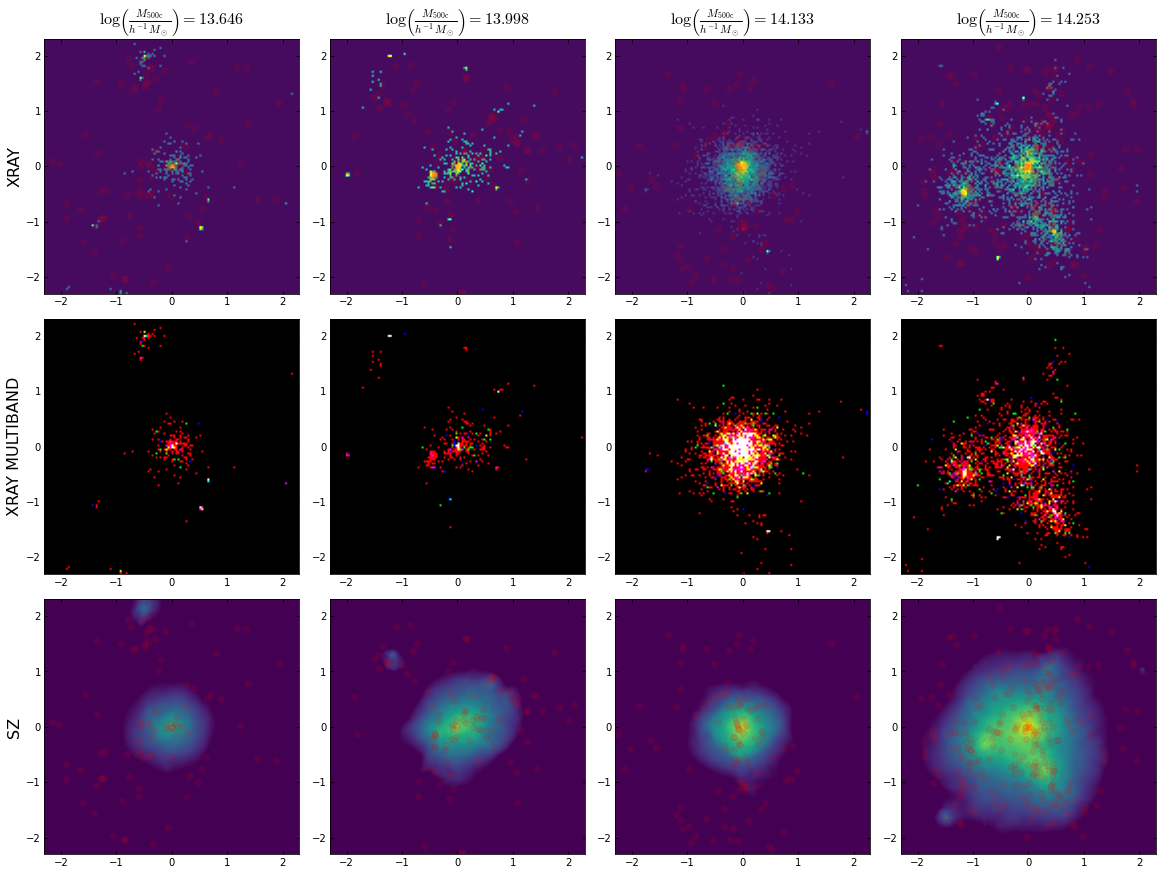

In [150]:
#as a sanity check, plot up a few clusters

n=4

aperture = newcat.par['aperture']

mbins = np.linspace(13.5, 14.5, n+1)

f = plt.figure(figsize=(20,15))
gs = mpl.gridspec.GridSpec(3,n, hspace=0.1, wspace=0.1)

for i in range(n):
    mask = (10**mbins[i] <= newcat.prop['m500c'].values) & (newcat.prop['m500c'].values <= 10**mbins[i+1])

    ind = np.random.choice(np.argwhere(mask).flatten())

    # X-ray
    ax = f.add_subplot(gs[0,i])

    im = newcat.ximgs[ind]

    ax.imshow(np.rot90(im), vmin=-0.5, vmax=10, #cmap='inferno',
              extent=[-aperture,aperture,-aperture,aperture])

    x = newcat.gal[ind]['xproj']
    y = newcat.gal[ind]['yproj']
    ax.plot(x,y,'ro', alpha=0.1)

    ax.set_title(r'$\log\left(\frac{M_\mathrm{500c}}{h^{-1}\,M_\odot}\right) = '
                 f'{np.log10(float(newcat.prop["m500c"][ind])):.3f}$',
                 fontsize=16)
    if i==0:
        ax.set_ylabel('XRAY', fontsize=16)
    
    
    # X-ray Multiband
    ax = f.add_subplot(gs[1,i])

    im = newcat.xmbimgs[ind]

    ax.imshow(np.rot90(im), vmin=-0.5, vmax=10, #cmap='inferno',
              extent=[-aperture,aperture,-aperture,aperture])
    if i==0:
        ax.set_ylabel('XRAY MULTIBAND', fontsize=16)

    # SZ
    ax = f.add_subplot(gs[2,i])

    im = newcat.simgs[ind]

    ax.imshow(np.flip(im,0), vmin=0.5, vmax=2, #cmap='inferno',
              extent=[-aperture,aperture,-aperture,aperture])

    x = newcat.gal[ind]['xproj']
    y = newcat.gal[ind]['yproj']
    ax.plot(x,y,'ro', alpha=0.1)
    if i==0:
        ax.set_ylabel('SZ', fontsize=16)
    
plt.tight_layout()
# plt.savefig('temp/mag_xraysz.png')

In [148]:
newcat.save(join(wdir, 'data_mocks', 'Magneticum_dynXraySZ_z=0.1-0.29_LOS-z_031122_contam.p'))

Pickle dumping to /hildafs/home/mho1/hilda/halo_cnn/data_mocks/Magneticum_dynXraySZ_z=0.1-0.29_LOS-z_031122_contam.p with protocol 4


# Scratch